In [1]:
import numpy as np
import random
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10

Using TensorFlow backend.


In [0]:
class DataSet:
    def __init__(self):
        lfw_people = fetch_lfw_people(min_faces_per_person=1, color = True)
        lfw_people_sub = self.preprocess_human_faces_dataset(lfw_people,7000)
        (train_faces, test_faces) = train_test_split(lfw_people_sub, test_size = 2000, random_state = 1)
        train_faces_label = 10*np.ones((5000, 1)).astype('int')
        test_faces_label = 10*np.ones((2000, 1)).astype('int')
        
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        
        self.train_data = self.normalize_data(np.concatenate((x_train, train_faces), axis = 0))
        self.test_data = self.normalize_data(np.concatenate((x_test, test_faces), axis = 0))
        self.train_labels = np.r_[y_train, train_faces_label]
        self.test_labels = np.r_[y_test, test_faces_label]
        
        
        self.shuffle_data()
        #idx_train = np.random.permutation(len(self.train_data))
        #self.train_data,self.train_labels = self.train_data[idx_train], self.train_labels[idx_train]
        
        idx_test = np.random.permutation(len(self.test_data))
        self.test_data,self.test_labels = self.test_data[idx_test], self.test_labels[idx_test]
        
        #print('train_data shape: {0}'.format(self.train_data.shape))
        #print('test_data shape: {0}'.format(self.test_data.shape))
        #print('train_labels shape: {0}'.format(self.train_labels.shape))
        #print('test_labels shape: {0}'.format(self.test_labels.shape))
        
        self.curr_training_step = 0
        self.curr_test_step = 0
        
    def shuffle_data(self):
        idx_train = np.random.permutation(len(self.train_data))
        self.train_data,self.train_labels = self.train_data[idx_train], self.train_labels[idx_train]
    
    def _normalize(self, image):
        min_val = np.min(image)
        max_val = np.max(image)
        image_norm = (image-min_val) / (max_val-min_val)
        return image_norm

    def normalize_data(self,data):
        images_norm = []
        for image in data:
            img_norm = self._normalize(image)
            images_norm.append(img_norm)
        return np.asarray(images_norm)
      
    def preprocess_human_faces_dataset(self, dataSet, size_new):
        random.seed(64)
        random.shuffle(dataSet.images)
        dataSet_sub = dataSet.images[:size_new]
        images_res = []
        for image in dataSet_sub:
            img_res = cv2.resize(image, (32, 32))
            images_res.append(img_res)
        return np.asarray(images_res)
    
    def get_train_set_size(self):
        return self.train_data.shape[0]

    def get_test_set_size(self):
        return self.test_data.shape[0]

    def to_one_hot(self, X):
        one_hot = np.zeros((len(X), 11))
        for i in range(len(X)):
            np.put(one_hot[i, :], X[i], 1)

        return one_hot
      
    # Helper function to plot some images in the dataset
    def plot_cifar10(self,class_name=None):
      mapping = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4,
                'dog': 5, 'fog': 6, 'horse': 7, 'ship': 8, 'truck': 9, 'human':10}

      if class_name == None:
        fig, ax = plt.subplots(11, 10, sharey=True, figsize=(11,10))
        for j in range(11):
          class_index = (self.train_labels == j)[:,0] #get all values in column 0 (from all rows)
          class_imgs =  self.train_data[class_index,:,:][np.random.choice(5000, 10),:,:]
          for i, img in enumerate(class_imgs):
            ax[j,i].imshow(img)
            ax[j,i].grid('off')
            ax[j,i].set_xticks([])
            ax[j,i].set_yticks([])
            if i == 0:
              ax[j,i].set_ylabel(list(mapping.keys())[j])
      else:
        class_index = (self.train_labels == mapping[class_name])[:,0]
        class_imgs = self.train_data[class_index,:,:][np.random.choice(5000, 10),:,:]
        fig, ax = plt.subplots(1, 10, sharey=True, figsize=(22,2))
        for i, img in enumerate(class_imgs):
          ax[i].imshow(img)
          ax[i].grid('off')
          ax[i].set_xticks([])
          ax[i].set_yticks([])
          if i == 0:
            ax[i].set_ylabel(class_name)

In [3]:
dataset = DataSet()

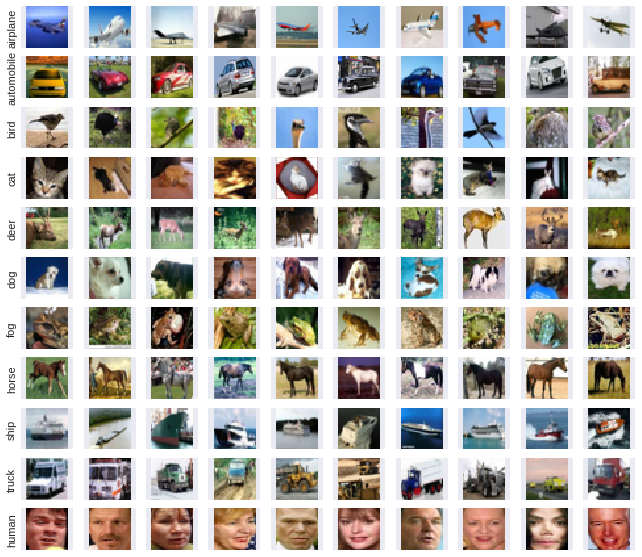

In [4]:
#dataset.plot_cifar10('human')

dataset.plot_cifar10()

In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras.datasets import cifar10
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.models import Sequential, load_model
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation, Dense, Flatten, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization

In [0]:
def MyNet(width, height, depth, classes):
    model = Sequential()
    input_shape = (height, width, depth)
    
    # First CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same', input_shape = input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # Second CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis = -1))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    
    # First set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(units = 512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    # Softmax classifier
    model.add(Dense(units = classes))
    model.add(Activation('softmax'))
    
    return model

In [7]:
optimizer = SGD(lr = 0.01, momentum = 0.9)
model = MyNet(32, 32, 3, 11)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
H = model.fit(dataset.train_data, dataset.to_one_hot(dataset.train_labels), batch_size = 512, validation_data = (dataset.test_data, dataset.to_one_hot(dataset.test_labels)), verbose = 1, epochs = 120)

Train on 55000 samples, validate on 12000 samples
Epoch 1/120
55000/55000 [==============================] - 16s 289us/step - loss: 1.7797 - acc: 0.4505 - val_loss: 1.5791 - val_acc: 0.5031
Epoch 2/120
55000/55000 [==============================] - 12s 212us/step - loss: 1.1331 - acc: 0.6006 - val_loss: 0.9418 - val_acc: 0.6722
Epoch 3/120
55000/55000 [==============================] - 12s 212us/step - loss: 0.9808 - acc: 0.6517 - val_loss: 0.8936 - val_acc: 0.6821
Epoch 4/120
55000/55000 [==============================] - 12s 212us/step - loss: 0.9020 - acc: 0.6820 - val_loss: 0.9160 - val_acc: 0.6805
Epoch 5/120
55000/55000 [==============================] - 12s 213us/step - loss: 0.8420 - acc: 0.7023 - val_loss: 0.7562 - val_acc: 0.7349
Epoch 6/120
55000/55000 [==============================] - 12s 212us/step - loss: 0.7983 - acc: 0.7176 - val_loss: 0.8187 - val_acc: 0.7173
Epoch 7/120
55000/55000 [==============================] - 12s 212us/step - loss: 0.7598 - acc: 0.7312 - val_l

In [8]:
# Evaluate the model
scores = model.evaluate(dataset.test_data, dataset.to_one_hot(dataset.test_labels))

print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

12000/12000 [==============================] - 2s 155us/step
Loss: 0.554
Accuracy: 0.862


In [0]:
def visualize_loss(model,num_epochs):
    history_dict = H.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, num_epochs+1)
    
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
  


In [0]:
def visualize_acc(model,num_epochs):
    history_dict = H.history
    epochs = range(1, num_epochs+1)
    acc_values = history_dict['acc']
    val_acc_values = history_dict['val_acc']
    
    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

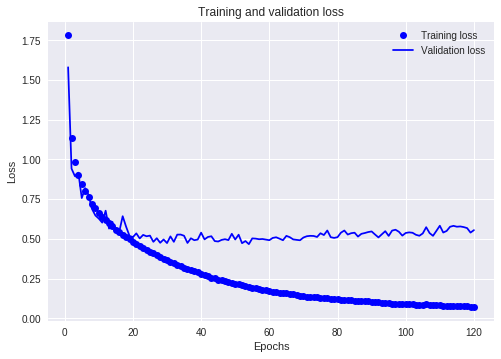

In [16]:
visualize_loss(H,120)

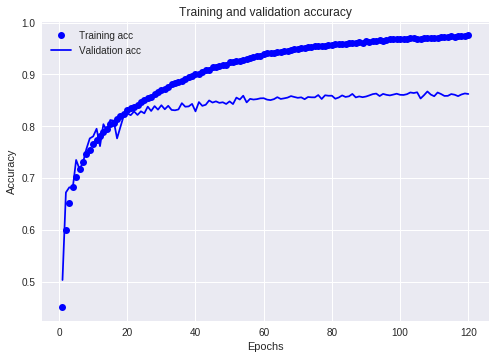

In [11]:
visualize_acc(H,120)

In [12]:
optimizer = Adagrad(lr=0.01, decay=1e-6)
model = MyNet(32, 32, 3, 11)
model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
H2 = model.fit(dataset.train_data, dataset.to_one_hot(dataset.train_labels), 
              batch_size = 512,
              validation_data = (dataset.test_data, dataset.to_one_hot(dataset.test_labels)),
              verbose = 1,
              shuffle=True,
              epochs = 120)

Train on 55000 samples, validate on 12000 samples
Epoch 1/120
55000/55000 [==============================] - 13s 238us/step - loss: 1.4671 - acc: 0.5246 - val_loss: 1.1452 - val_acc: 0.5986
Epoch 2/120
55000/55000 [==============================] - 12s 216us/step - loss: 0.9691 - acc: 0.6605 - val_loss: 0.8501 - val_acc: 0.7010
Epoch 3/120
55000/55000 [==============================] - 12s 216us/step - loss: 0.8405 - acc: 0.7063 - val_loss: 0.7640 - val_acc: 0.7331
Epoch 4/120
55000/55000 [==============================] - 12s 216us/step - loss: 0.7616 - acc: 0.7338 - val_loss: 0.7643 - val_acc: 0.7326
Epoch 5/120
55000/55000 [==============================] - 12s 215us/step - loss: 0.7057 - acc: 0.7545 - val_loss: 0.7335 - val_acc: 0.7467
Epoch 6/120
55000/55000 [==============================] - 12s 217us/step - loss: 0.6600 - acc: 0.7689 - val_loss: 0.6750 - val_acc: 0.7642
Epoch 7/120
55000/55000 [==============================] - 12s 217us/step - loss: 0.6256 - acc: 0.7803 - val_l

In [13]:
# Evaluate the model
scores = model.evaluate(dataset.test_data, dataset.to_one_hot(dataset.test_labels))
print('Loss: %.3f' % scores[0])
print('Accuracy: %.3f' % scores[1])

12000/12000 [==============================] - 2s 156us/step
Loss: 0.579
Accuracy: 0.849


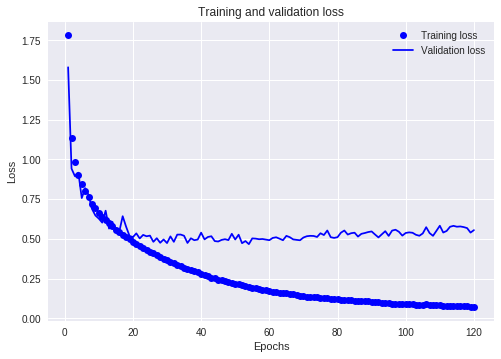

In [14]:
visualize_loss(H2,120)

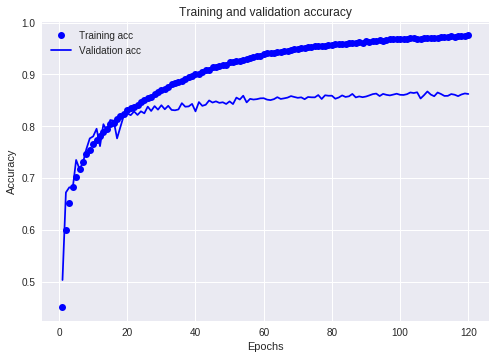

In [15]:
visualize_acc(H2,120)